## DataFiniti Dataset

In [176]:
import pandas as pd
from io import StringIO
import os
# Path to your file
path = r"C:\Users\admin\OneDrive\Desktop\Project_ML_Mariya_17\datafiniti.csv"

# Check if file exists
print("Checking if file exists:", os.path.exists(path))
try:
    # Read the file content
    with open(path, "r", encoding="utf-8", errors="replace") as f:
        content = f.read()

    # Read CSV content into DataFrame
    df = pd.read_csv(StringIO(content), on_bad_lines='skip', low_memory=False)

    # Show all column names
    print("\n:receipt: Columns in your CSV file:\n")
    for col in df.columns:
        print("-", col)
        
    # Show first few rows
    print("\n:bar_chart: Sample data:\n")
    print(df.head())
except Exception as e:
    print(":x: Failed to read the file:", e)

Checking if file exists: True

:receipt: Columns in your CSV file:

- id
- address
- apiURLs
- assessedValues
- brokers
- buildingName
- city
- companies
- congressionalDistrictHouse
- country
- county
- countyFIPS
- currentOwnerType
- dateAdded
- dateUpdated
- deposits
- descriptions
- domains
- estimatedPrices
- features
- fees
- floorSizeValue
- floorSizeUnit
- geoLocation
- imageURLs
- instrumentNumber
- keys
- languagesSpoken
- latitude
- leasingTerms
- legalDescription
- legalRange
- listingName
- longitude
- lotSizeValue
- lotSizeUnit
- managedBy
- mostRecentPriceAmount
- mostRecentPriceDomain
- mostRecentPriceSourceURL
- mostRecentPriceDate
- mostRecentPriceFirstDateSeen
- mostRecentBrokerAgent
- mostRecentBrokerCompany
- mostRecentBrokerEmails
- mostRecentBrokerPhones
- mostRecentBrokerDateSeen
- mostRecentPriceAmount.1
- mostRecentPriceDomain.1
- mostRecentPricePerSquareFoot
- mostRecentPriceSourceURL.1
- mostRecentPriceDate.1
- mostRecentPriceFirstDateSeen.1
- mostRecentRent

In [177]:
df.columns

Index(['id', 'address', 'apiURLs', 'assessedValues', 'brokers', 'buildingName',
       'city', 'companies', 'congressionalDistrictHouse', 'country',
       ...
       'propertyType', 'province', 'reviews', 'rules', 'subdivision',
       'sourceURLs', 'statuses', 'taxID', 'transactions', 'yearBuilt'],
      dtype='object', length=102)

In [178]:
df.index

RangeIndex(start=0, stop=100, step=1)

## Datafiniti cleaning

In [179]:
import pandas as pd
import json

def clean_datafiniti(df):
    def extract_price(transactions):
        try:
            if pd.isna(transactions):
                return None
            if isinstance(transactions, str):
                transactions = json.loads(transactions.replace("'", "\""))
            if isinstance(transactions, list) and len(transactions) > 0:
                return transactions[0].get("price") or transactions[0].get("priceAmount") or transactions[0].get("amount")
        except:
            return None

    df['price'] = df['transactions'].apply(extract_price)

    df['yearBuilt'] = pd.to_numeric(df['yearBuilt'], errors='coerce').fillna(0).astype(int)

    df_cleaned = df.rename(columns={
        'address': 'address',
        'city': 'city',
        'province': 'province',
        'country': 'country'
    })

    selected_cols = ['address', 'city', 'province', 'country', 'yearBuilt', 'price']
    df_cleaned = df_cleaned[selected_cols]

    df_cleaned = df_cleaned.dropna(subset=['address', 'city', 'price'])

    print("Cleaned Datafiniti DataFrame shape:", df_cleaned.shape)
    return df_cleaned

In [180]:
df = pd.read_csv(r"C:\Users\admin\OneDrive\Desktop\Project_ML_Mariya_17\datafiniti.csv")
df_clean = clean_datafiniti(df)

# save cleaned DataFrame to CSV
df_clean.to_csv("datafiniti_cleaned.csv", index=False)
print("Saved cleaned Datafiniti data to datafiniti_cleaned.csv")

Cleaned Datafiniti DataFrame shape: (64, 6)
Saved cleaned Datafiniti data to datafiniti_cleaned.csv


In [181]:
df_clean = clean_datafiniti(df)
df_clean.head()

Cleaned Datafiniti DataFrame shape: (64, 6)


,address,city,province,country,yearBuilt,price
0,506 Haverhill Ln,Safety Harbor,FL,US,1988,342500.0
2,5320 Forest Park Dr,North Fort Myers,FL,US,1976,37000.0
3,4450 58th Ave N,Saint Petersburg,FL,US,1951,28000.0
9,780 Hanbury Dr,Des Plaines,IL,US,2006,222000.0
10,707 HANBURY DR,DES PLAINES,IL,US,2005,125000.0


In [182]:
df_clean.index

Index([ 0,  2,  3,  9, 10, 15, 16, 19, 20, 21, 23, 24, 26, 27, 29, 30, 31, 32,
       33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 45, 50, 52, 54, 55, 57, 58, 59,
       61, 63, 65, 66, 67, 70, 72, 74, 75, 77, 78, 79, 81, 83, 84, 85, 86, 87,
       88, 89, 90, 91, 92, 94, 95, 96, 97, 99],
      dtype='int64')

## ATTOM Dataset

In [183]:
import requests
import pandas as pd

# ATTOM API setup
base_url = "https://api.gateway.attomdata.com/propertyapi/v1.0.0/property/address"
headers = {
    "accept": "application/json",
    "apikey": "e9300a9dfdc4c8aed4af7c5a08449a33"
}

# Fetch 5 pages × 100 = 500 rows
all_properties = []
pages_to_fetch = 5
pagesize = 100

for page in range(1, pages_to_fetch + 1):
    params = {
        "postalcode": "82009",  # Valid ZIP code (Cheyenne, WY)
        "page": str(page),
        "pagesize": str(pagesize)
    }

    response = requests.get(base_url, headers=headers, params=params)

    if response.status_code == 200:
        data = response.json()
        properties = data.get("property", [])
        if isinstance(properties, list):
            all_properties.extend(properties)
        else:
            all_properties.append(properties)
        print(f"Page {page} fetched: {len(properties)} records")
    else:
        print(f"Page {page} failed - Status {response.status_code}")
        print(response.text)
        break  # Stop if any page fails

# Convert to DataFrame
if all_properties:
    df = pd.json_normalize(all_properties, sep='_')
    df.to_csv("attom_raw.csv", index=False)
    print(f"\nTotal rows saved: {len(df)} to attom_raw.csv")
    display(df.head())
else:
    print("No data fetched.")

Page 1 fetched: 100 records
Page 2 fetched: 100 records
Page 3 fetched: 100 records
Page 4 fetched: 100 records
Page 5 fetched: 100 records

Total rows saved: 500 to attom_raw.csv


,identifier_Id,identifier_fips,identifier_apn,identifier_attomId,address_country,address_countrySubd,address_line1,address_line2,address_locality,address_matchCode,...,location_geoid,location_geoIdV4_CO,location_geoIdV4_CS,location_geoIdV4_DB,location_geoIdV4_N4,location_geoIdV4_PL,location_geoIdV4_SB,location_geoIdV4_ZI,vintage_lastModified,vintage_pubDate
0,180053,56021,16885000400010,180053,US,WY,4009 CARLA DR,"CHEYENNE, WY 82009",CHEYENNE,ExaStr,...,"CO56021, CS5690715, DB5601980, PL5613900, RS00...",16856031afb1b236f0d628bb802eac71,29392c8fb7766fb633eb98b90048e74f,30c86a3f2f5c848363c435461b716572,22b24a91277613b572bb847840bad23d,802b98230660b6ebebd36a06ec9e541e,"2adc253f6a9750a26911d38c6cd21b9b, a12b93bb835a...",ac6c213665a7701bd3617ada1ff96513,2025-07-22,2025-07-22
1,228520,56021,18015000247070,228520,US,WY,4707 HICKORY PL,"CHEYENNE, WY 82009",CHEYENNE,ExaStr,...,"CO56021, CS5690715, DB5601980, PL5613900, RS00...",16856031afb1b236f0d628bb802eac71,29392c8fb7766fb633eb98b90048e74f,30c86a3f2f5c848363c435461b716572,ac4725a7497f492cc0bda6e12e09ed2d,802b98230660b6ebebd36a06ec9e541e,"2adc253f6a9750a26911d38c6cd21b9b, 9ef520046d8a...",ac6c213665a7701bd3617ada1ff96513,2025-07-22,2025-07-22
2,239936,56021,11054000400170,239936,US,WY,252 E IDAHO ST,"CHEYENNE, WY 82009",CHEYENNE,ExaStr,...,"CO56021, CS5690770, DB5601980, PL5663800, RS00...",16856031afb1b236f0d628bb802eac71,e5a490a174895893b11ce251b6cea7bd,30c86a3f2f5c848363c435461b716572,NaN,d3249a2aecfeabe2a060e532ab7d2ad4,"744f36341a01a573d4ff7c61ea2cc7ed, 13e2c61b7838...",ac6c213665a7701bd3617ada1ff96513,2025-07-22,2025-07-22
3,240202,56021,11054000900012,240202,US,WY,9420 MICHIGAN ST,"CHEYENNE, WY 82009",CHEYENNE,ExaStr,...,"CO56021, CS5690770, DB5601980, PL5663800, SB00...",16856031afb1b236f0d628bb802eac71,e5a490a174895893b11ce251b6cea7bd,30c86a3f2f5c848363c435461b716572,NaN,d3249a2aecfeabe2a060e532ab7d2ad4,"744f36341a01a573d4ff7c61ea2cc7ed, 13e2c61b7838...",ac6c213665a7701bd3617ada1ff96513,2025-07-22,2025-07-22
4,263622,56021,13923000600141,263622,US,WY,4717 MORAN AVE,"CHEYENNE, WY 82009",CHEYENNE,ExaStr,...,"CO56021, CS5690715, DB5601980, PL5613900, RS00...",16856031afb1b236f0d628bb802eac71,29392c8fb7766fb633eb98b90048e74f,30c86a3f2f5c848363c435461b716572,5c0988930d223ac4d02a8c930641c123,802b98230660b6ebebd36a06ec9e541e,"9ef520046d8a93b1b5320e8b9f7dcf2f, 2adc253f6a97...",ac6c213665a7701bd3617ada1ff96513,2025-07-22,2025-07-22


In [184]:
df

,identifier_Id,identifier_fips,identifier_apn,identifier_attomId,address_country,address_countrySubd,address_line1,address_line2,address_locality,address_matchCode,...,location_geoid,location_geoIdV4_CO,location_geoIdV4_CS,location_geoIdV4_DB,location_geoIdV4_N4,location_geoIdV4_PL,location_geoIdV4_SB,location_geoIdV4_ZI,vintage_lastModified,vintage_pubDate
0,180053,56021,16885000400010,180053,US,WY,4009 CARLA DR,"CHEYENNE, WY 82009",CHEYENNE,ExaStr,...,"CO56021, CS5690715, DB5601980, PL5613900, RS00...",16856031afb1b236f0d628bb802eac71,29392c8fb7766fb633eb98b90048e74f,30c86a3f2f5c848363c435461b716572,22b24a91277613b572bb847840bad23d,802b98230660b6ebebd36a06ec9e541e,"2adc253f6a9750a26911d38c6cd21b9b, a12b93bb835a...",ac6c213665a7701bd3617ada1ff96513,2025-07-22,2025-07-22
1,228520,56021,18015000247070,228520,US,WY,4707 HICKORY PL,"CHEYENNE, WY 82009",CHEYENNE,ExaStr,...,"CO56021, CS5690715, DB5601980, PL5613900, RS00...",16856031afb1b236f0d628bb802eac71,29392c8fb7766fb633eb98b90048e74f,30c86a3f2f5c848363c435461b716572,ac4725a7497f492cc0bda6e12e09ed2d,802b98230660b6ebebd36a06ec9e541e,"2adc253f6a9750a26911d38c6cd21b9b, 9ef520046d8a...",ac6c213665a7701bd3617ada1ff96513,2025-07-22,2025-07-22
2,239936,56021,11054000400170,239936,US,WY,252 E IDAHO ST,"CHEYENNE, WY 82009",CHEYENNE,ExaStr,...,"CO56021, CS5690770, DB5601980, PL5663800, RS00...",16856031afb1b236f0d628bb802eac71,e5a490a174895893b11ce251b6cea7bd,30c86a3f2f5c848363c435461b716572,NaN,d3249a2aecfeabe2a060e532ab7d2ad4,"744f36341a01a573d4ff7c61ea2cc7ed, 13e2c61b7838...",ac6c213665a7701bd3617ada1ff96513,2025-07-22,2025-07-22
3,240202,56021,11054000900012,240202,US,WY,9420 MICHIGAN ST,"CHEYENNE, WY 82009",CHEYENNE,ExaStr,...,"CO56021, CS5690770, DB5601980, PL5663800, SB00...",16856031afb1b236f0d628bb802eac71,e5a490a174895893b11ce251b6cea7bd,30c86a3f2f5c848363c435461b716572,NaN,d3249a2aecfeabe2a060e532ab7d2ad4,"744f36341a01a573d4ff7c61ea2cc7ed, 13e2c61b7838...",ac6c213665a7701bd3617ada1ff96513,2025-07-22,2025-07-22
4,263622,56021,13923000600141,263622,US,WY,4717 MORAN AVE,"CHEYENNE, WY 82009",CHEYENNE,ExaStr,...,"CO56021, CS5690715, DB5601980, PL5613900, RS00...",16856031afb1b236f0d628bb802eac71,29392c8fb7766fb633eb98b90048e74f,30c86a3f2f5c848363c435461b716572,5c0988930d223ac4d02a8c930641c123,802b98230660b6ebebd36a06ec9e541e,"9ef520046d8a93b1b5320e8b9f7dcf2f, 2adc253f6a97...",ac6c213665a7701bd3617ada1ff96513,2025-07-22,2025-07-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,8828243,56021,18265000100160,8828243,US,WY,400 E CARLSON ST,"CHEYENNE, WY 82009",CHEYENNE,ExaStr,...,"CO56021, CS5690715, DB5601980, PL5613900, RS00...",16856031afb1b236f0d628bb802eac71,29392c8fb7766fb633eb98b90048e74f,30c86a3f2f5c848363c435461b716572,079e8e8fabf45c64bfbf5db0d878a7eb,802b98230660b6ebebd36a06ec9e541e,"744f36341a01a573d4ff7c61ea2cc7ed, 13e2c61b7838...",ac6c213665a7701bd3617ada1ff96513,2025-07-22,2025-07-22
496,8828258,56021,12364000200050,8828258,US,WY,4801 MOUNTAIN RD,"CHEYENNE, WY 82009",CHEYENNE,ExaStr,...,"CO56021, CS5690715, DB5601980, PL5613900, SB00...",16856031afb1b236f0d628bb802eac71,29392c8fb7766fb633eb98b90048e74f,30c86a3f2f5c848363c435461b716572,e43b630f809ae2cd918a8ed63d15966d,802b98230660b6ebebd36a06ec9e541e,"5b88c062457fc7330a81dec74b026e41, 2adc253f6a97...",ac6c213665a7701bd3617ada1ff96513,2025-07-22,2025-07-22
497,8828259,56021,12364000200010,8828259,US,WY,4800 KING ARTHUR WAY,"CHEYENNE, WY 82009",CHEYENNE,ExaStr,...,"CO56021, CS5690715, DB5601980, PL5613900, RS00...",16856031afb1b236f0d628bb802eac71,29392c8fb7766fb633eb98b90048e74f,30c86a3f2f5c848363c435461b716572,e43b630f809ae2cd918a8ed63d15966d,802b98230660b6ebebd36a06ec9e541e,"5b88c062457fc7330a81dec74b026e41, 2adc253f6a97...",ac6c213665a7701bd3617ada1ff96513,2025-07-22,2025-07-22
498,8828260,56021,12364000100010,8828260,US,WY,4801 KING ARTHUR WAY,"CHEYENNE, WY 82009",CHEYENNE,ExaStr,...,"CO56021, CS5690715, DB5601980, PL5613900, RS00...",16856031afb1b236f0d628bb802eac71,29392c8f

In [185]:
df.columns

Index(['identifier_Id', 'identifier_fips', 'identifier_apn',
       'identifier_attomId', 'address_country', 'address_countrySubd',
       'address_line1', 'address_line2', 'address_locality',
       'address_matchCode', 'address_oneLine', 'address_postal1',
       'address_postal2', 'address_postal3', 'location_accuracy',
       'location_latitude', 'location_longitude', 'location_distance',
       'location_geoid', 'location_geoIdV4_CO', 'location_geoIdV4_CS',
       'location_geoIdV4_DB', 'location_geoIdV4_N4', 'location_geoIdV4_PL',
       'location_geoIdV4_SB', 'location_geoIdV4_ZI', 'vintage_lastModified',
       'vintage_pubDate'],
      dtype='object')

## ATTOM cleaning

In [186]:
import requests
import pandas as pd

url = "https://api.gateway.attomdata.com/propertyapi/v1.0.0/property/address"
headers = {
    "accept": "application/json",
    "apikey": "e9300a9dfdc4c8aed4af7c5a08449a33"
}
params = {
    "postalcode": "82009",
    "page": "1",
    "pagesize": "50"
}

response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    print("API Success")
    data = response.json()
    properties = data.get("property", [])
    
    if not properties:
        print("No property data found in response.")
    else:
        df_attom_raw = pd.json_normalize(properties, sep="_")

        def clean_attom(df):
            df_cleaned = df.rename(columns={
                'address_line1': 'address',
                'address_locality': 'city',
                'address_countrySubd': 'province',
                'address_country': 'country',
                'building_yearBuilt': 'yearBuilt'
            })

            if 'yearBuilt' not in df_cleaned.columns:
                df_cleaned['yearBuilt'] = None

            df_cleaned['price'] = None

            selected_cols = ['address', 'city', 'province', 'country', 'yearBuilt', 'price']
            df_cleaned = df_cleaned[selected_cols]
            df_cleaned = df_cleaned.dropna(subset=['address', 'city'])
            df_cleaned['yearBuilt'] = pd.to_numeric(df_cleaned['yearBuilt'], errors='coerce').fillna(0).astype(int)

            return df_cleaned

        df_attom_clean = clean_attom(df_attom_raw)
        print("Cleaned Data:")
        print(df_attom_clean)
else:
    print("Failed to fetch data from Attom API:", response.status_code)
    print(response.text)


API Success
Cleaned Data:
                 address      city province country  yearBuilt price
0          4009 CARLA DR  CHEYENNE       WY      US          0  None
1        4707 HICKORY PL  CHEYENNE       WY      US          0  None
2         252 E IDAHO ST  CHEYENNE       WY      US          0  None
3       9420 MICHIGAN ST  CHEYENNE       WY      US          0  None
4         4717 MORAN AVE  CHEYENNE       WY      US          0  None
5       4701 ONTARIO AVE  CHEYENNE       WY      US          0  None
6    6901 WILLSHIRE BLVD  CHEYENNE       WY      US          0  None
7         4755 MORAN AVE  CHEYENNE       WY      US          0  None
8          729 APACHE ST  CHEYENNE       WY      US          0  None
9    7812 YELLOWSTONE RD  CHEYENNE       WY      US          0  None
10     1442 GILCHRIST RD  CHEYENNE       WY      US          0  None
11        4756 MORAN AVE  CHEYENNE       WY      US          0  None
12   1767 POWDERHOUSE RD  CHEYENNE       WY      US          0  None
13   132

## Merging ATTOM & Datafiniti

In [187]:
import pandas as pd
import json

def clean_datafiniti(df):
    def extract_price(transactions):
        try:
            if pd.isna(transactions):
                return None
            if isinstance(transactions, str):
                transactions = json.loads(transactions.replace("'", "\""))
            if isinstance(transactions, list) and len(transactions) > 0:
                return transactions[0].get("price") or transactions[0].get("priceAmount") or transactions[0].get("amount")
        except:
            return None

    df['price'] = df['transactions'].apply(extract_price)
    df['yearBuilt'] = pd.to_numeric(df['yearBuilt'], errors='coerce').fillna(0).astype(int)

    df_cleaned = df.rename(columns={
        'address': 'address',
        'city': 'city',
        'province': 'province',
        'country': 'country'
    })

    selected_cols = ['address', 'city', 'province', 'country', 'yearBuilt', 'price']
    df_cleaned = df_cleaned[selected_cols]
    df_cleaned = df_cleaned.dropna(subset=['address', 'city', 'price'])

    return df_cleaned

def clean_attom(df):
    df_cleaned = df.rename(columns={
        'address_line1': 'address',
        'address_locality': 'city',
        'address_countrySubd': 'province',
        'address_country': 'country',
        'building_yearBuilt': 'yearBuilt'
    })

    if 'yearBuilt' not in df_cleaned.columns:
        df_cleaned['yearBuilt'] = None

    df_cleaned['price'] = None

    selected_cols = ['address', 'city', 'province', 'country', 'yearBuilt', 'price']
    df_cleaned = df_cleaned[selected_cols]
    df_cleaned = df_cleaned.dropna(subset=['address', 'city'])
    df_cleaned['yearBuilt'] = pd.to_numeric(df_cleaned['yearBuilt'], errors='coerce').fillna(0).astype(int)

    return df_cleaned

In [188]:
df_datafiniti_raw = pd.read_csv(r"C:\Users\admin\OneDrive\Desktop\Project_ML_Mariya_17\datafiniti.csv", low_memory=False)

In [189]:
df_merged = pd.concat([
    clean_datafiniti(df_datafiniti_raw),
    clean_attom(df_attom_raw)
], ignore_index=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_17208\565954061.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_merged = pd.concat([


In [190]:
print("Merged shape:", df_merged.shape)
print(df_merged.head(10))

df_merged.to_csv("merged_real_estate.csv", index=False)

df_merged

Merged shape: (114, 6)
               address              city province country  yearBuilt     price
0     506 Haverhill Ln     Safety Harbor       FL      US       1988  342500.0
1  5320 Forest Park Dr  North Fort Myers       FL      US       1976   37000.0
2      4450 58th Ave N  Saint Petersburg       FL      US       1951   28000.0
3       780 Hanbury Dr       Des Plaines       IL      US       2006  222000.0
4       707 HANBURY DR       DES PLAINES       IL      US       2005  125000.0
5      7782 Dutch Loop  Colorado Springs       CO      US       2013  299500.0
6         1163 Fay Ave             Largo       FL      US       1963     100.0
7          204 Roat St      Lehigh Acres       FL      US       1995   13900.0
8       201 Telfair Ct       Summerville       SC      US       1983  190000.0
9     453 Seaworthy Rd  North Fort Myers       FL      US       1991  261000.0


,address,city,province,country,yearBuilt,price
0,506 Haverhill Ln,Safety Harbor,FL,US,1988,342500.0
1,5320 Forest Park Dr,North Fort Myers,FL,US,1976,37000.0
2,4450 58th Ave N,Saint Petersburg,FL,US,1951,28000.0
3,780 Hanbury Dr,Des Plaines,IL,US,2006,222000.0
4,707 HANBURY DR,DES PLAINES,IL,US,2005,125000.0
...,...,...,...,...,...,...
109,2308 PATTISON AVE,CHEYENNE,WY,US,0,NaN
110,2312 APACHE ST,CHEYENNE,WY,US,0,NaN
111,5201 TEN SLEEP DR,CHEYENNE,WY,US,0,NaN
112,5110 KING ARTHUR WAY,CHEYENNE,WY,US,0,NaN


## Modelling

In [191]:
# Step A: load the lib.
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

In [192]:
# Step 1: Load your cleaned data
df = pd.read_csv(r"C:\Users\admin\OneDrive\Desktop\Project_ML_Mariya_17\Project_ML_Mariya_17\merged_real_estate.csv")
print("Loaded data. Shape:", df.shape)

Loaded data. Shape: (114, 6)


In [193]:
# Step 2: Drop rows with missing price (target)
df = df.dropna(subset=["price"])

In [194]:
# Step 3: Select features (X) and target (y)
features = ["yearBuilt"]
X = df[features]
y = df["price"]

In [195]:
# Step 4: Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data split: ", X_train.shape, X_test.shape)

Data split:  (51, 1) (13, 1)


In [196]:
import numpy as np

# Models
model_linear = LinearRegression()
model_tree = DecisionTreeRegressor(random_state=0)
model_forest = RandomForestRegressor(random_state=0)
model_boosting = GradientBoostingRegressor(random_state=0)

# Train
model_linear.fit(X_train, y_train)
model_tree.fit(X_train, y_train)
model_forest.fit(X_train, y_train)
model_boosting.fit(X_train, y_train)

# predictions
pred_linear = model_linear.predict(X_test)
pred_tree = model_tree.predict(X_test)
pred_forest = model_forest.predict(X_test)
pred_boosting = model_boosting.predict(X_test)

#-------------------------------------- COMMENT -----------------------------------
# We are using three different models:
# - Linear Regression: to serve as a simple baseline
# - Decision Tree: good for non-linear relationships
# - Random Forest: more robust and often gives better performance
# - Gradient Boosting: improves predictions by correcting previous mistakes step-by-step

print("Linear Regression:")
print("MAE:", mean_absolute_error(y_test, pred_linear))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_linear)))
print("R²:", r2_score(y_test, pred_linear))

print("\n Decision Tree:")
print("MAE:", mean_absolute_error(y_test, pred_tree))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_tree)))
print("R²:", r2_score(y_test, pred_tree))

print("\n Random Forest:")
print("MAE:", mean_absolute_error(y_test, pred_forest))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_forest)))
print("R²:", r2_score(y_test, pred_forest))

print("\n Gradient Boosting:")
print("MAE:", mean_absolute_error(y_test, pred_boosting))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_boosting)))
print("R²:", r2_score(y_test, pred_boosting))

#-------------------------------------- COMMENT -----------------------------------
# Evaluation metrics used:
# - MAE (Mean Absolute Error): shows average error in price
# - RMSE (Root Mean Square Error): penalizes larger errors
# - R² Score: tells how well the model fits the data (closer to 1 is better)

import joblib

# Save your trained Gradient Boosting model
joblib.dump(model_boosting, "model.pkl")
print(" Model saved as model.pkl")

Linear Regression:
MAE: 226688.6240721721
RMSE: 265346.7898178708
R²: -0.3402344360395855

 Decision Tree:
MAE: 269926.92307692306
RMSE: 464841.7197531617
R²: -3.1130434299779584

 Random Forest:
MAE: 264880.1371080586
RMSE: 378002.659905797
R²: -1.7198365677741467

 Gradient Boosting:
MAE: 248499.93258543077
RMSE: 435217.1514834623
R²: -2.6054966889681266
 Model saved as model.pkl


## Plotting

In [197]:
# Step 1: Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

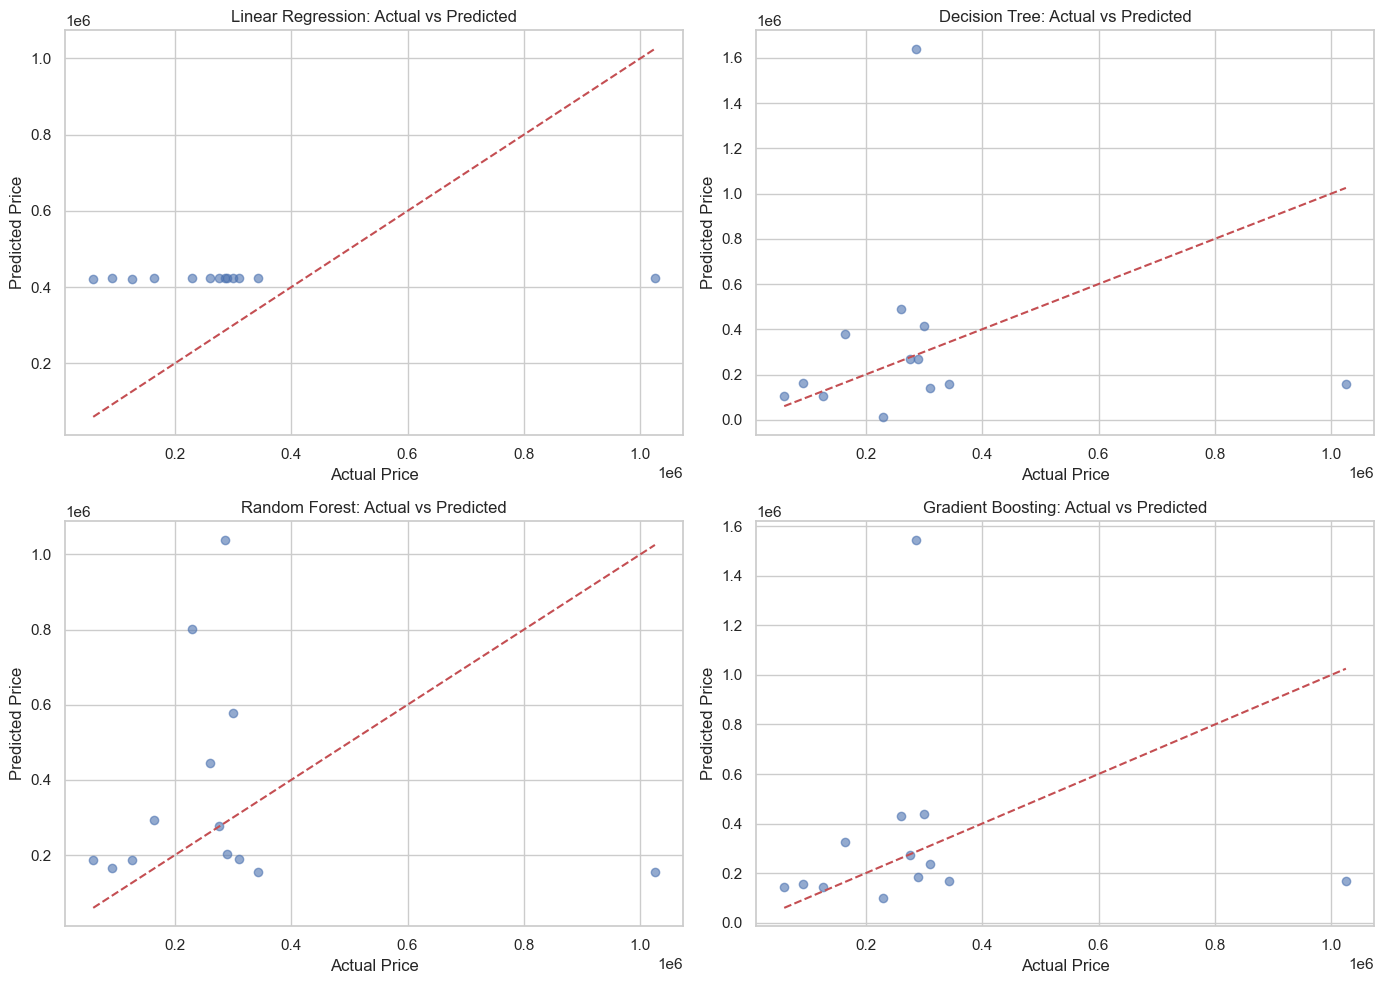

In [198]:
# Step 2: Scatter Plots — Actual vs Predicted for all models

# Get predictions
pred_linear = model_linear.predict(X_test)
pred_tree = model_tree.predict(X_test)
pred_forest = model_forest.predict(X_test)
pred_boosting = model_boosting.predict(X_test)

# Store predictions in a dictionary
predictions = {
    "Linear Regression": pred_linear,
    "Decision Tree": pred_tree,
    "Random Forest": pred_forest,
    "Gradient Boosting": pred_boosting
}

# Create subplots: 2 rows x 2 columns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # makes it easy to loop over

# Plot each model
for i, (model_name, preds) in enumerate(predictions.items()):
    axes[i].scatter(y_test, preds, alpha=0.6)
    axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axes[i].set_title(f"{model_name}: Actual vs Predicted")
    axes[i].set_xlabel("Actual Price")
    axes[i].set_ylabel("Predicted Price")

# Final layout
plt.tight_layout()
plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_17208\4273246823.py:23: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


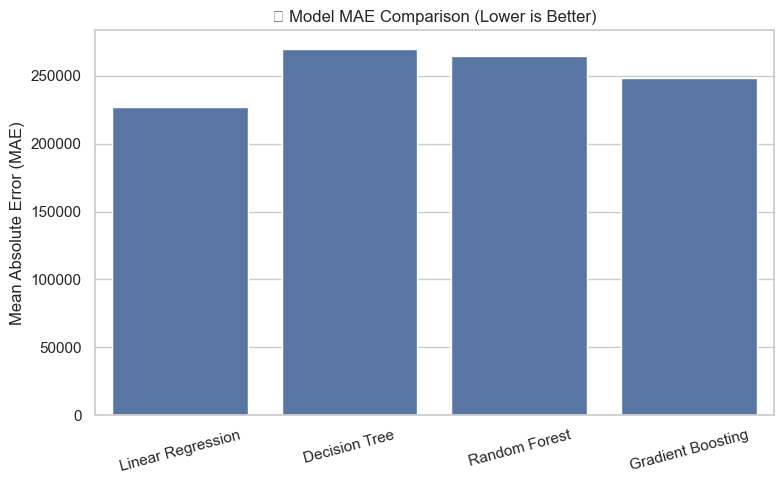

In [199]:
# Step 3: Bar Chart — Compare MAE of all models

# Get predictions
pred_linear = model_linear.predict(X_test)
pred_tree = model_tree.predict(X_test)
pred_forest = model_forest.predict(X_test)
pred_boosting = model_boosting.predict(X_test)

# Calculate MAEs
mae_scores = {
    "Linear Regression": mean_absolute_error(y_test, pred_linear),
    "Decision Tree": mean_absolute_error(y_test, pred_tree),
    "Random Forest": mean_absolute_error(y_test, pred_forest),
    "Gradient Boosting": mean_absolute_error(y_test, pred_boosting)
}

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=list(mae_scores.keys()), y=list(mae_scores.values()))
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("📊 Model MAE Comparison (Lower is Better)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()